<a href="https://colab.research.google.com/github/nadgir-praveen/data-science-lab/blob/main/assignments/SC_M2_NB_MiniProject_5_Customer_Segmentation_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Customer segmentation using clustering

## Learning Objectives

At the end of the experiment, you will be able to :

* extract summary level insight from a given customer dataset.

* handle the missing data and identify the underlying pattern or structure of the data.

* create an unsupervised model that generates the optimum number of segments for the customer base

* identify customer segments based on the overall buying behaviour


## Dataset

The dataset chosen for this mini project is the Online Retail dataset. It is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

The dataset contains 541909 records, and each record is made up of 8 fields.

To know more about the dataset : [click here](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

## Information

**Clustering** is the task of grouping together a set of objects so that the objects in the same cluster are more similar to each other than to objects in other clusters. Similarity is a measure that reflects the strength of the relationship between two data objects.

In the clustering calculation, K-Means is a very popular algorithm. In this analysis, this method is used to cluster the similar data items.

In Retail and E-Commerce (B2C), and more broadly in B2B, one of the key elements shaping the business strategy of a firm is understanding of customer behaviour. More specifically, understanding the customers based on different business metrics: how much they spend (revenue), how often they spend (frequency), are they new or existing customers, what are their favorite products, etc... Such understanding in turn helps direct marketing, sales, account management and product teams to support customers on a personalized level and improve the product offering.

Furthermore, segmenting customers into different categories based on similar/cyclical buying pattern over a period of 1 year helps the retail shops manage their inventory better, thereby lowering costs and raising revenues by placing the orders in sync with the buying cycles.

## Problem Statement

Perform customer segmentation for an Online Retail using an Unsupervised Clustering technique

## Grading = 10 Points

### Import Required packages

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

## Data Wrangling

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Online_Retail.zip
!unzip -qq Online_Retail.zip

## Load the data

In [ ]:
# YOUR CODE HERE
df_train = pd.read_csv('/content/Online_Retail_Train.csv')

In [ ]:
df_train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom
3,576652,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,2011-11-16 10:39:00,1.95,17198.0,United Kingdom
4,546157,22180,RETROSPOT LAMP,2,2011-03-10 08:40:00,9.95,13502.0,United Kingdom


In [ ]:
df_train.shape

(27096, 8)

## Data Pre-processing (2 points)

Explore the dataset by performing the following operations:

* There is a lot of redundant data. Identify such data and take appropriate action.

  **Hint:** refer to this [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

* Most Invoices appear as normal transactions with positive quantity and prices, but there are some prefixed with "C" or "A" which denote different transaction types. Invoice starting with C represents cancelled order and A represents the Adjusted. Identify such data and take appropriate action.

  **Hint:** Check the negative values in Quantity column for all cancelled orders

* Handle the null values by dropping or filling with appropriate mean


* Some of the transactions based on the `StockCode` variable are not actually products, but representing the costs or fees regarding to the post or bank or other tansactions. Find such data and handle it accordingly.

  Hint:
    - The transaction with `'POST' 'PADS' 'M' 'DOT' 'C2' 'BANK CHARGES'` as their `StockCodes` are considered as irrelevant transactions.

* Identify the outliers in the UntiPrice and Quantity and handle them accordingly.

  **Hint:** [link](https://kanoki.org/2020/04/23/how-to-remove-outliers-in-python/)

* Create a DayOfWeek column using `InvoiceDate`, Hint: pd.to_datetime()

**Note:** Perform all the above operations using a function to reuse and apply the same for test data.

In [ ]:
df_train.describe()

,Quantity,UnitPrice,CustomerID
count,27096.000000,27096.000000,20279.000000
mean,9.547535,5.080545,15263.936338
std,42.986573,115.684282,1714.125912
min,-2376.000000,0.000000,12347.000000
25%,1.000000,1.250000,13924.000000
50%,3.000000,2.100000,15079.000000
75%,10.000000,4.130000,16768.500000
max,2880.000000,13541.330000,18287.000000


In [ ]:
df_train.describe(include = 'O')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,27096,27096,27027,27096,27096
unique,11040,3052,3097,10554,36
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-10-31 14:41:00,United Kingdom
freq,65,123,123,65,24697


In [ ]:
df_train['UnitPrice'].min()

0.0

In [ ]:
from scipy.stats import iqr
IQR = iqr(df_train['UnitPrice'], axis=0)
IQR

2.88

In [ ]:
# calculate the lower and upper bound
def outlier_limit_by_iqr(colSeries):
  Q1 = np.quantile(colSeries,0.25)
  Q3 = np.quantile(colSeries,0.75)
  IQR = Q3 - Q1
  lower = Q1-1.5*IQR
  upper = Q3+1.5*IQR
  return lower, upper

In [ ]:
# YOUR CODE HERE
def eda(data):

    print("Before dropping duplicates :",data.shape)
    data = data.drop_duplicates()#drop duplicates
    print("After dropping duplicates :",data.shape)
    print(data.isna().sum())
    #print("Percentage of customers missing: ", round(data['CustomerID'].isnull().sum() * 100 / len(data),2),"%" )
    #to remove cancelled orders
    data = data[~data['InvoiceNo'].astype(str).str.contains('C')]
    data = data[~data['InvoiceNo'].astype(str).str.contains('A')]
    data = data.dropna(subset = ['CustomerID'])
    print(data.isna().sum())
    wrong_stockcodes = ['POST','PADS','M','DOT','C2','BANK CHARGES']
    print("Before Dropping Irrelevant StockCodes:\n")
    print(data.shape)
    data.drop(data[data.StockCode.isin(wrong_stockcodes)].index, inplace=True)
    print("After Dropping Irrelevant StockCodes:\n")
    print(data.shape)
    l, u = outlier_limit_by_iqr(df_train.Quantity)
    print (f'Lower, Upper Bounds {l} , {u}')
    print (f'Number of records after IQR on Quantity - {data[data.Quantity.between(l,u)].shape[0]} ')
    print (f'Records Removed - {data.shape[0] - data[data.Quantity.between(l,u)].shape[0]}')
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek
    return data



In [ ]:
temp_df = eda(df_train)

Before dropping duplicates : (27096, 8)
After dropping duplicates : (27082, 8)
InvoiceNo         0
StockCode         0
Description      69
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     6817
Country           0
dtype: int64
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
Before Dropping Irrelevant StockCodes:

(19794, 8)
After Dropping Irrelevant StockCodes:

(19710, 8)
Lower, Upper Bounds -12.5 , 23.5
Number of records after IQR on Quantity - 16978 
Records Removed - 2732


In [ ]:
temp_df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DayOfWeek
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom,2
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom,4
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom,3
3,576652,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,2011-11-16 10:39:00,1.95,17198.0,United Kingdom,2
4,546157,22180,RETROSPOT LAMP,2,2011-03-10 08:40:00,9.95,13502.0,United Kingdom,3


In [ ]:
temp_df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
DayOfWeek      0
dtype: int64

## Understanding new insights from the data (1 point)

1.  Are there any free items in the data? How many are there?

2.  Find the number of transactions per country and visualize using an appropriate plot

3.  What is the ratio of customers who are repeat purchasers vs single-time purchasers? Visualize using an appropriate plot.

4. Plot heatmap showing unit price per month and day of the week

  **Hint:** Month name as index on Y-axis, Day of the week on X-axis

5. Find the top 10 customers who bought the most no.of items. Also find the top 10 Items bought by most no.of customers.

In [ ]:
free_items = temp_df[temp_df['UnitPrice']==0]
print(len(free_items),free_items)

2       InvoiceNo StockCode                          Description  Quantity  \
12859    564651     23268  SET OF 2 CERAMIC CHRISTMAS REINDEER       192   
13724    554037     22619            SET OF 6 SOLDIER SKITTLES        80   

              InvoiceDate  UnitPrice  CustomerID      Country  DayOfWeek  
12859 2011-08-26 14:19:00        0.0     14646.0  Netherlands          4  
13724 2011-05-20 14:13:00        0.0     12415.0    Australia          4  


The transactions with a unit price of zero are relatively few in number (33 transactions). These transactions have a large variability in the quantity of items involved, ranging from 1 to 12540, with a substantial standard deviation. Including these transactions in the clustering analysis might introduce noise and could potentially distort the customer behavior patterns identified by the clustering algorithm.

Strategy:

Given the small number of these transactions and their potential to introduce noise in the data analysis, the strategy should be to remove these transactions from the dataset. This would help in maintaining a cleaner and more consistent dataset.

In [ ]:
#temp_df = temp_df[temp_df['UnitPrice'] > 0]

In [ ]:
temp_df.shape

(19710, 9)

In [ ]:
transcation_per_country = (temp_df['InvoiceNo']
                            .groupby(temp_df['Country'])
                            .agg('count')
                            .sort_values(ascending=False)[0:])

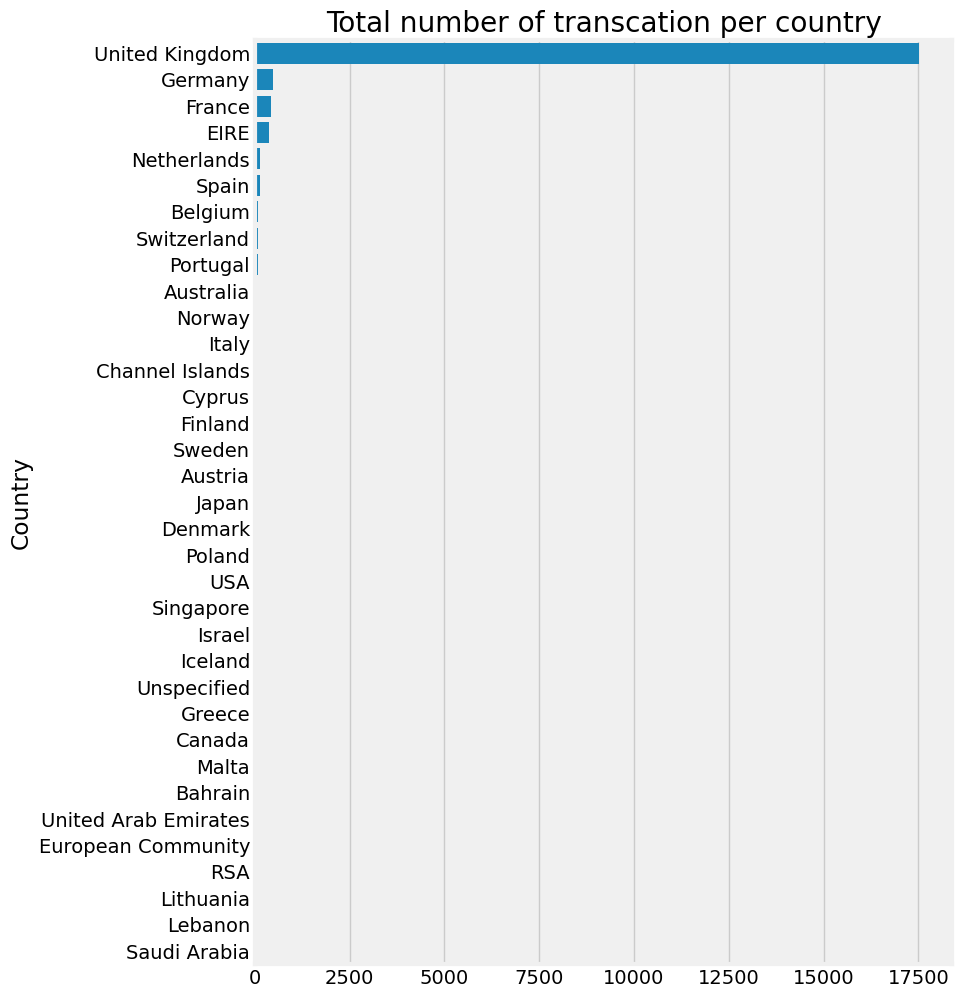

In [ ]:
plt.figure(figsize=(9,12))
plt.style.use('fivethirtyeight')
sns.barplot(x = transcation_per_country.values,
              y = transcation_per_country.index
              )
plt.title("Total number of transcation per country")

plt.show()

It seems most of our orders(~90%) is in United Kingdom.

In [ ]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

In [ ]:
def ratio_Of_RepeatVsSingleCustomer(df, col):
  number_of_time_purchase = df[col].value_counts()
  single_customer = []
  repeat_customer = []
  for value in number_of_time_purchase.values:
    if value == 1:
      single_customer.append(value)
    else:
      repeat_customer.append(value)
  print(len(single_customer))
  print(len(repeat_customer))
  print("Ration of Repeat Customer vs. Single Customer:")
  print(np.round(len(repeat_customer)/len(single_customer),2))
  explode = [0.0, 0.2]
  type_of_customer = ["Single Customer", "Repeat Customer"]
  data = [len(single_customer), len(repeat_customer)]
  # Creating plot
  fig = plt.figure(figsize =(10, 7))
  plt.pie(data, labels =type_of_customer, explode= explode,autopct=lambda pct: func(pct, data))

 # show plot
  plt.show()
  return single_customer, repeat_customer

808
2499
Ration of Repeat Customer vs. Single Customer:
3.09


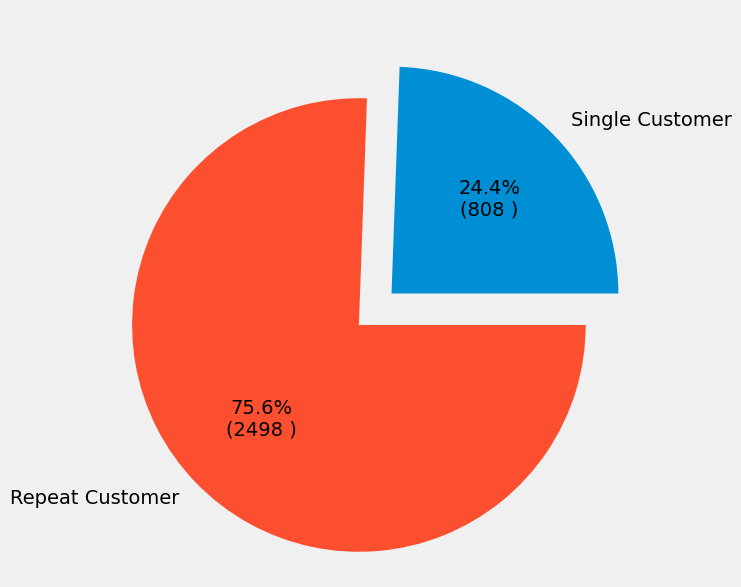

In [ ]:
single_cusotmer, repeat_customer = ratio_Of_RepeatVsSingleCustomer(temp_df, 'CustomerID')


In [ ]:
def split_date_parts(df):
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
  df['InvoiceMonth'] = pd.DatetimeIndex(df['InvoiceDate']).month
  df['InvoiceDOW'] = pd.DatetimeIndex(df['InvoiceDate']).dayofweek

In [ ]:
split_date_parts(temp_df)

In [ ]:
temp_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DayOfWeek,InvoiceMonth,InvoiceDOW
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom,2,6,2
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom,4,5,4
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom,3,4,3
3,576652,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,2011-11-16 10:39:00,1.95,17198.0,United Kingdom,2,11,2
4,546157,22180,RETROSPOT LAMP,2,2011-03-10 08:40:00,9.95,13502.0,United Kingdom,3,3,3


<Axes: xlabel='InvoiceMonth', ylabel='InvoiceDOW'>

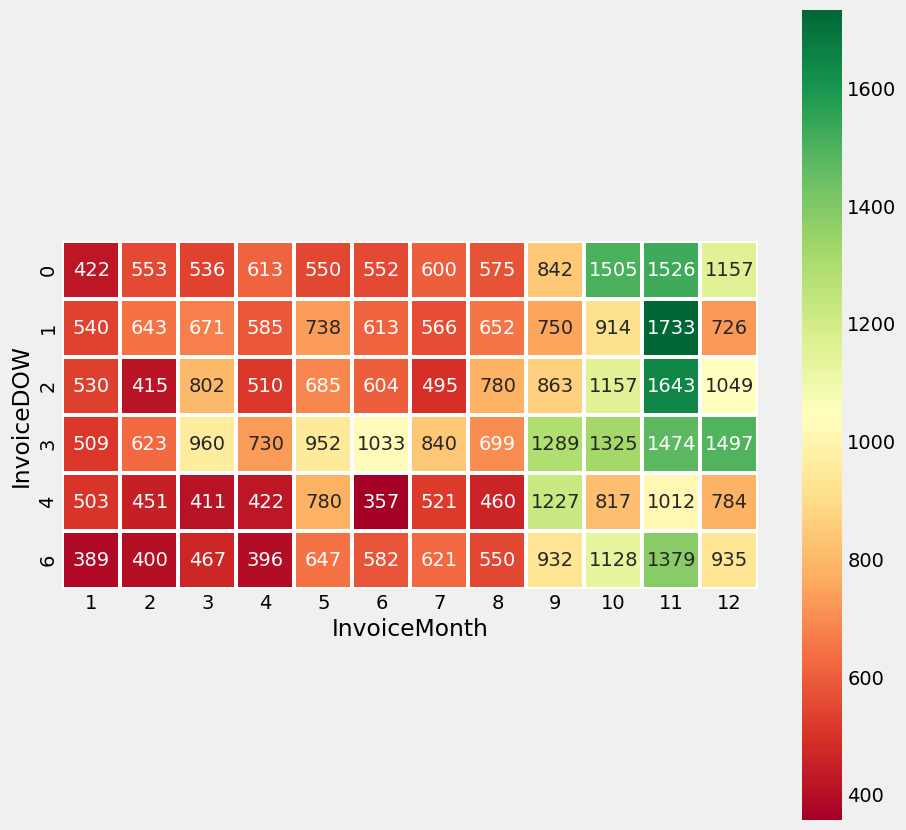

In [ ]:
UnitPrices = temp_df.pivot_table(index='InvoiceMonth',columns='InvoiceDOW',values='UnitPrice',aggfunc='sum')
plt.figure(figsize=(10,10))
sns.heatmap(UnitPrices.T,fmt='0.00f',linewidths=1.5,cmap='RdYlGn',square=True,annot=True)

In [ ]:
top10_customer_By_Item = (temp_df['Quantity']
                            .groupby(temp_df['CustomerID'])
                            .agg('sum')
                            .sort_values(ascending=False)
                            .iloc[:10])
top10_customer_By_Item

CustomerID
14646.0    12427
14911.0     4507
14298.0     3663
14156.0     3258
15769.0     3062
16333.0     3024
12415.0     3017
13694.0     2956
16684.0     2894
16754.0     2880
Name: Quantity, dtype: int64

In [ ]:
top10_Items_By_CustomerCount = (temp_df['CustomerID']
                                .groupby(temp_df['Description'])
                                .agg('count').sort_values(ascending=False)
                                .iloc[:10])
top10_Items_By_CustomerCount

Description
WHITE HANGING HEART T-LIGHT HOLDER    107
JUMBO BAG RED RETROSPOT                83
ASSORTED COLOUR BIRD ORNAMENT          81
REGENCY CAKESTAND 3 TIER               75
PAPER CHAIN KIT 50'S CHRISTMAS         64
PARTY BUNTING                          62
LUNCH BAG SPACEBOY DESIGN              60
LUNCH BAG CARS BLUE                    59
ALARM CLOCK BAKELIKE RED               56
NATURAL SLATE HEART CHALKBOARD         56
Name: CustomerID, dtype: int64

## Feature Engineering and Transformation (2 points)

### Create new features to uncover better insights and drop the unwanted columns

* Create a new column which represents Total amount spent by each customer

    **Hint:** Quantity * UnitPrice

* Customer IDs are seen to be repeated. Maintain unique customer IDs by grouping and summing up all possible observations per customer.

    **Hint:** [pandas.groupby.agg](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)

**Note:** Perform the above operations in function, to reuse and apply the same for test data

In [ ]:
def create_total(df, col1, col2):
  df['Total'] = df[col1] * df[col2]
  return df

In [ ]:
df_trainCopy = create_total(temp_df, col1='UnitPrice', col2='Quantity')

### 1. Recency:
We fix a reference date for finding the recent transactions. The reference date would be a day after the most recent transaction date in the dataset. Then we calculate the days difference between the most recent transaction carried out by the customer and this reference date

In [ ]:
import datetime as dt
def findRecentTranscation(df, col1=None, col2= None, col3=None):
  referenceDate = df[col1].max()
  referenceDate += dt.timedelta(days = 1)
  df['Recency'] = (referenceDate - df[col1]).astype("timedelta64[D]")
  df_CustomerHistory = df.groupby(col2).min().reset_index()[[col2, col3]]
  return df_CustomerHistory

In [ ]:
df_CustomerHistory_train = findRecentTranscation(df_trainCopy, 'InvoiceDate', 'CustomerID', 'Recency')
df_CustomerHistory_train.head(5)

,CustomerID,Recency
0,12347.0,2.0
1,12348.0,319.0
2,12349.0,19.0
3,12353.0,204.0
4,12354.0,232.0


###Frequency
Calculate the frequency of transcations for each customer



In [ ]:
def calculateFreq_Of_Transctions(df, col1, col2):
  df_CustomerFreq = df[[col1, col2]].groupby(col1).count().reset_index()
  #print(df_CustomerFreq)
  df_CustomerFreq.rename(columns={col2:'Frequency'}, inplace=True)
  df_CustomerHistory = findRecentTranscation(df, 'InvoiceDate', 'CustomerID', 'Recency')
  df_CustomerHistory = df_CustomerHistory.merge(df_CustomerFreq, how='outer')
  return df_CustomerHistory

In [ ]:
df_CustomerHistory_train = calculateFreq_Of_Transctions(df_trainCopy, 'CustomerID', 'Total')
df_CustomerHistory_train.head()

,CustomerID,Recency,Frequency
0,12347.0,2.0,11
1,12348.0,319.0,1
2,12349.0,19.0,5
3,12353.0,204.0,2
4,12354.0,232.0,3


###Monetary Function
Finding total amount spent per customer

In [ ]:
def calculateMonetryValue_Of_Transctions(df, col1, col2):
  df_CustomerMonetryValue = df[[col1, col2]].groupby(col1).sum().reset_index()
  #print(df_CustomerFreq)
  df_CustomerMonetryValue.rename(columns={col2:'TotalValue'}, inplace=True)
  df_CustomerHistory = calculateFreq_Of_Transctions(df, col1, col2)
  df_CustomerHistory = df_CustomerHistory.merge(df_CustomerMonetryValue, how='outer')
  return df_CustomerHistory

In [ ]:
df_CustomerHistory_train = calculateMonetryValue_Of_Transctions(df_trainCopy, 'CustomerID', 'Total')
df_CustomerHistory_train.head()

,CustomerID,Recency,Frequency,TotalValue
0,12347.0,2.0,11,218.20
1,12348.0,319.0,1,41.76
2,12349.0,19.0,5,112.54
3,12353.0,204.0,2,59.70
4,12354.0,232.0,3,41.35


### Scale the data

Apply `StandardScaler` on the features.

The data was highly skewed and one of the major limitations of k-means is the curse of dimensionality. At first when I applied the k-means without removing the skewness of data, all the clusters we mixed and didn’t segregate properly. Therefore, I need to apply log transformations to reduce the skewness of each variable.

In [ ]:
import math

In [ ]:
# YOUR CODE HERE for scaling
def logTransform_N_Scale(df, col1 = None, col2 = None, col3=None):
  #df = calculateMonetryValue_Of_Transctions(df, 'CustomerID',col3)
  df['log_Recency'] = df[col1].apply(math.log)
  df['log_Frequency'] = df[col2].apply(math.log)
  df['log_TotalValue'] = df[col3].apply(math.log)
  #print(df.head())
  X = df.loc[:,['log_Recency','log_Frequency', 'log_TotalValue']]

  ## Standard Scaler
  scaler = StandardScaler().fit(X)
  X_scaled = scaler.transform(X)
  X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
  return X_scaled, df

In [ ]:
X_train, df_CustomerHistory_train = (logTransform_N_Scale(df_CustomerHistory_train,
                          'Recency',
                          'Frequency',
                          'TotalValue'))
X_train[:5]

,log_Recency,log_Frequency,log_TotalValue
0,-2.393472,1.215649,1.185803
1,1.334383,-1.245179,-0.092855
2,-0.738816,0.406499,0.673787
3,1.005795,-0.533840,0.183523
4,1.100326,-0.117733,-0.100485


## Clustering ( 5 points)

### Apply k-means algorithm to identify a specific number of clusters


* Fit the k-means model

* Extract and store the cluster centroids

Below are the parameters for k-means, which are helpful

**n_clusters** is no. of clusters specified

**k-means++** is a random initialization method for centroids to avoid random initialisation trap

**max_iter** is max no of iterations defined when k-means is running

**n_init** is no. of times k-means will run with different initial centroids

[why-is-k-means-slower-than-random-initialization-k-means](https://stats.stackexchange.com/questions/185396/why-is-k-means-slower-than-random-initialization-k-means/185422)

In [ ]:
# YOUR CODE HERE to apply KMeans
kmeans = KMeans(n_clusters = 4,
                init = 'k-means++',
                max_iter = 1000,
                n_init = 10)
kmeans.fit(X_train)

KMeans(max_iter=1000, n_clusters=4, n_init=10)

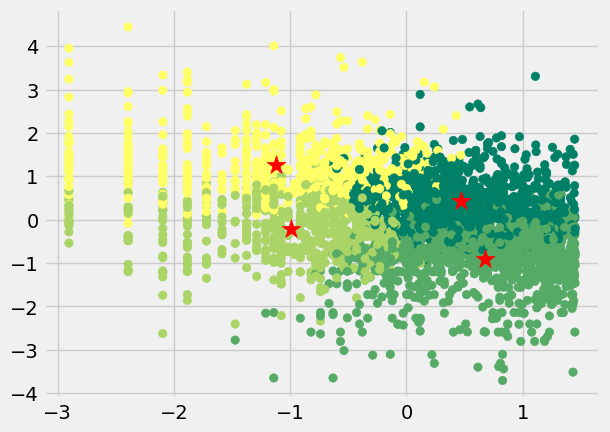

In [ ]:
y_predict = kmeans.fit_predict(X_train)
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,2], c=y_predict, cmap = 'summer')
plt.scatter(x = kmeans.cluster_centers_[:,0], y = kmeans.cluster_centers_[:,2], c = 'r', marker="*", s = 200)
plt.show()
plt.show()

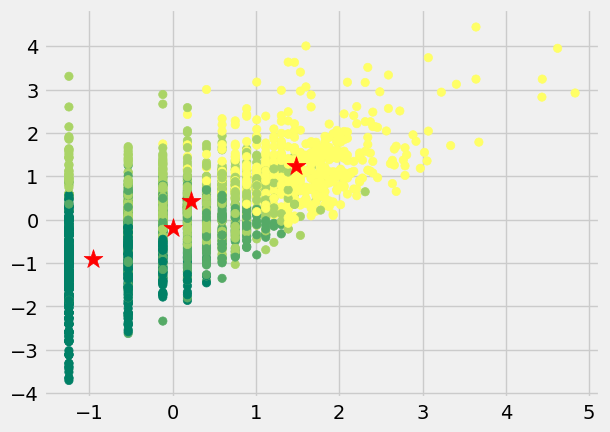

In [ ]:
y_predict = kmeans.fit_predict(X_train)
plt.scatter(X_train.iloc[:,1], X_train.iloc[:,2], c=y_predict, cmap = 'summer')
plt.scatter(x = kmeans.cluster_centers_[:,1], y = kmeans.cluster_centers_[:,2], c = 'r', marker="*", s = 200)
plt.show()
plt.show()

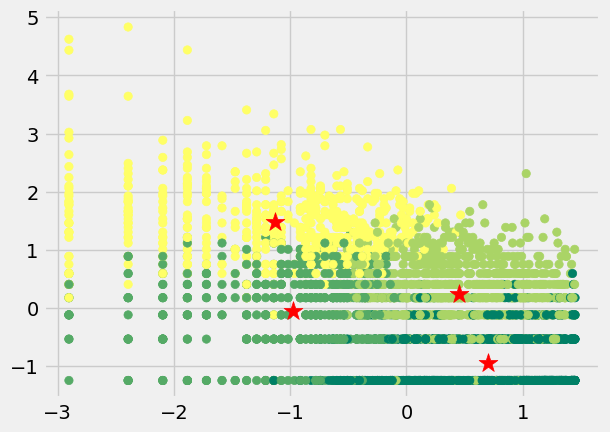

In [ ]:
y_predict = kmeans.fit_predict(X_train)
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,1], c=y_predict, cmap = 'summer')
plt.scatter(x = kmeans.cluster_centers_[:,0], y = kmeans.cluster_centers_[:,1], c = 'r', marker="*", s = 200)
plt.show()
plt.show()

In [ ]:
kmeans.cluster_centers_

array([[ 0.69884823, -0.94574138, -0.89310053],
       [-0.97304248, -0.05461726, -0.25731742],
       [ 0.45475857,  0.24109339,  0.43895371],
       [-1.13197463,  1.47169613,  1.23850622]])

In [ ]:
len(kmeans.labels_)

3307

#### Find the optimal number of clusters (K) by using the [Elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

Use the optimal no. of clusters and store the cluster centroids

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

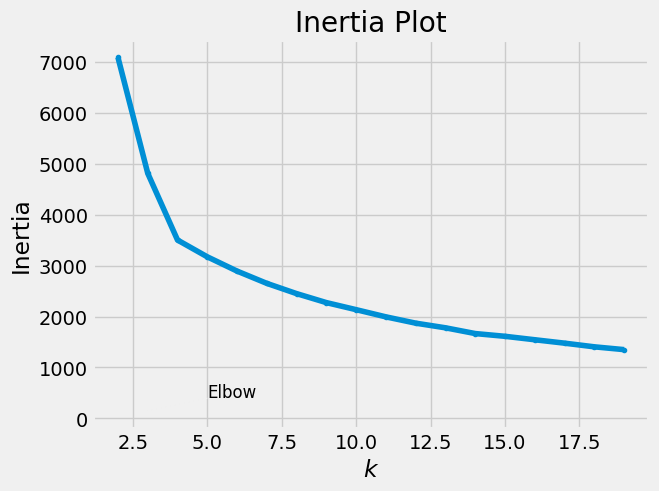

In [ ]:
# YOUR CODE HERE

clusters = np.arange(2,20)
inertia = []
for c in clusters:
    kmeans1 = KMeans(n_clusters = c,init='k-means++', max_iter= 1000, random_state=1)
    kmeans1.fit(X_train)
    inertia.append(kmeans1.inertia_)
plt.plot(clusters, inertia, marker= '.')
plt.arrow(5, 400, -2, -252)
plt.text(5, 410, "Elbow", fontdict={'size': 12})
plt.title('Inertia Plot')
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.show()

In [ ]:
kmeans1 = KMeans(n_clusters = 4,init='k-means++', random_state=1)
y_kmeans_train = kmeans1.fit_predict(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
print(y_kmeans_train)

[1 0 3 ... 0 1 0]


In [ ]:
kmeans1.labels_

array([5, 2, 1, ..., 2, 5, 8], dtype=int32)

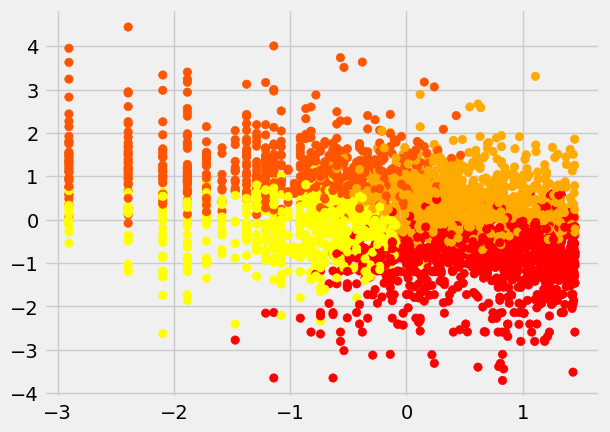

In [ ]:
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,2], c=y_kmeans_train, cmap = 'autumn')
plt.show()

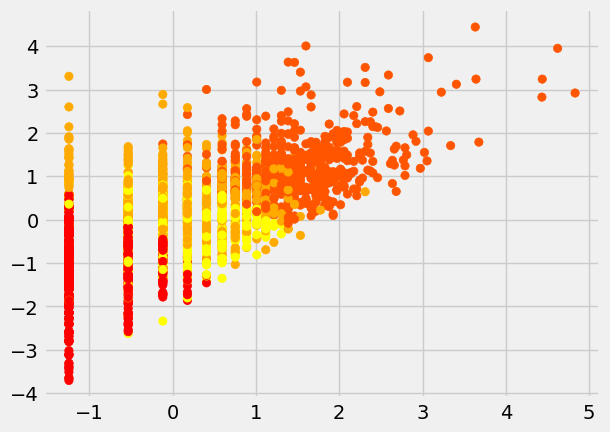

In [ ]:
plt.scatter(X_train.iloc[:,1], X_train.iloc[:,2], c=y_kmeans_train, cmap = 'autumn')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

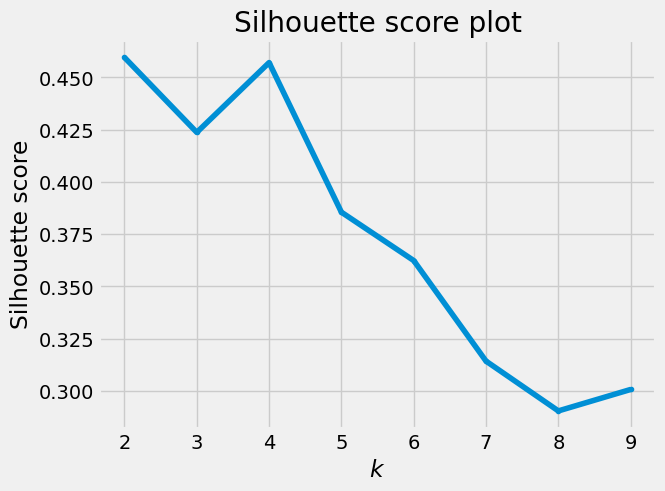

In [ ]:
# Plot Silhouette score plot
from sklearn.metrics import silhouette_score

clusters = np.arange(2,10)
sil_score = []
for c in clusters:
    kmeans2 = KMeans(n_clusters = c,init='k-means++', random_state=1)
    kmeans2.fit(X_train)
    sil_score.append(silhouette_score(X_train, kmeans2.labels_))
plt.plot(clusters, sil_score, marker= '.')
plt.title('Silhouette score plot')
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


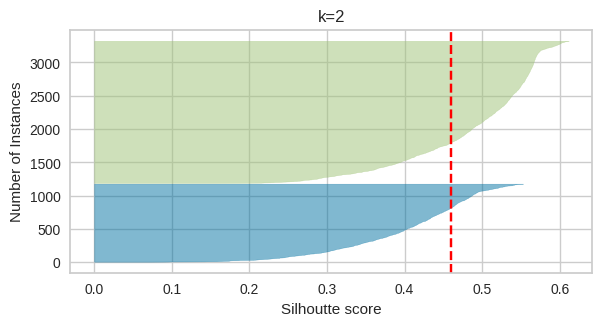

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


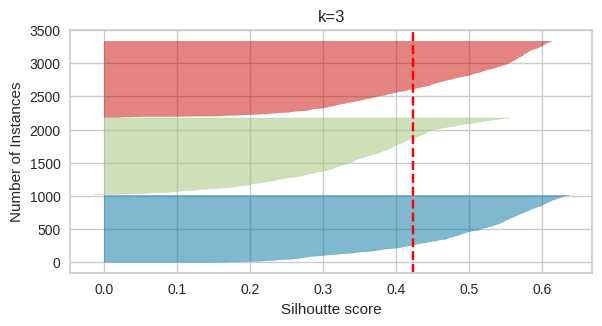

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


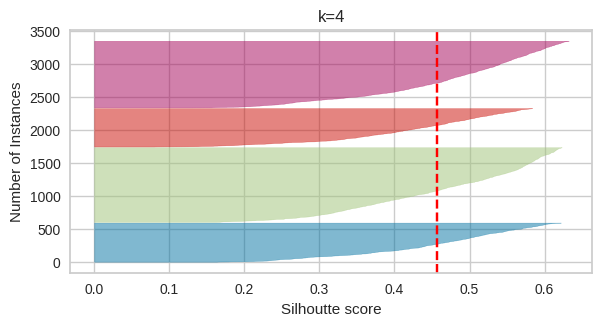

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


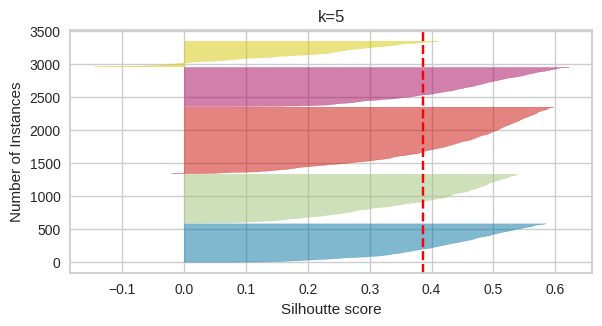

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
clusters = [2, 3, 4,5]
for c in clusters:
    plt.figure(figsize=(6, 3))
    # Instantiate the clustering model and visualizer
    kmeans3 = KMeans(n_clusters = c,init='k-means++', random_state=1)
    # Instantiate SilhouetteVisualizer()
    visualizer = SilhouetteVisualizer(kmeans3, colors='yellowbrick')
    # Fit the data to the visualizer
    visualizer.fit(X_train);
    plt.title("k={}".format(c))
    plt.xlabel("Silhoutte score")
    plt.ylabel("Number of Instances")
    plt.show()

### Apply DBSCAN algorithm for clustering

- Compare the results of clusters from k-means and DBSCAN


In [ ]:
# YOUR CODE HERE
dbscan = DBSCAN(eps=0.25, min_samples=26)
dbscan.fit(X_train)
print("Unique clusters in data: ", np.unique(dbscan.labels_))

Unique clusters in data:  [-1  0  1  2  3  4  5  6]


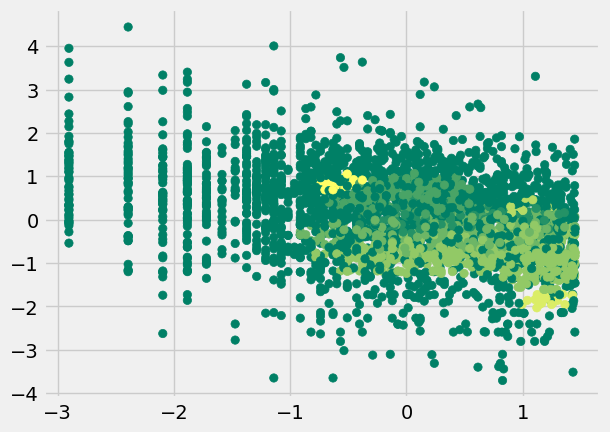

In [ ]:
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,2], c = dbscan.labels_, cmap= "summer")

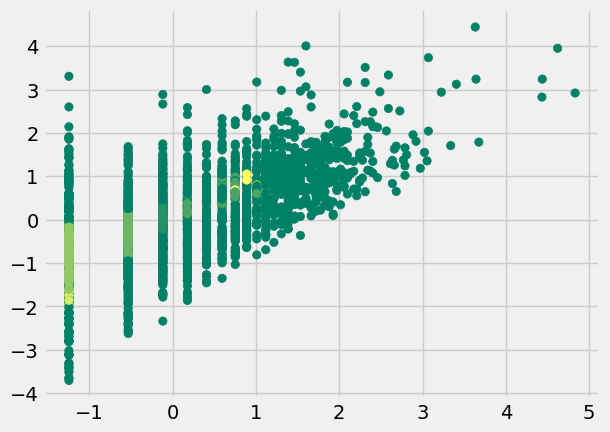

In [ ]:
plt.scatter(X_train.iloc[:,1], X_train.iloc[:,2], c = dbscan.labels_, cmap= "summer")

In [ ]:
num_of_core_instns = len(dbscan.core_sample_indices_)
print("Number of core instances: ", num_of_core_instns)

core_instns_indices = dbscan.core_sample_indices_
print("First 10 core instances indices: ", core_instns_indices[0:10])

core_instns = dbscan.components_
print("First 10 core instances: \n", core_instns[0:10])

Number of core instances:  881
First 10 core instances indices:  [ 4 10 15 16 22 27 30 33 35 40]
First 10 core instances: 
 [[ 1.10032598e+00 -1.17724845e-01 -1.00485178e-01]
 [ 1.16657303e-03  1.77516844e-01  4.52188051e-01]
 [ 1.06342972e-01 -5.33844634e-01 -1.10840150e-01]
 [ 1.03752537e+00 -1.17724845e-01  9.55417707e-02]
 [ 6.86433763e-02  4.06524089e-01  3.95723434e-01]
 [ 3.17783826e-01 -5.33844634e-01 -3.40928420e-01]
 [ 1.05119983e+00 -1.24520611e+00 -6.69948170e-01]
 [-8.89438027e-02 -1.17724845e-01 -6.52078559e-02]
 [ 1.34354217e+00 -5.33844634e-01 -1.82273973e-01]
 [-3.33055857e-01 -1.24520611e+00 -8.84645403e-01]]


### Analyze the clusters


- consider two features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** 2D plot

- consider three features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** [3D plot](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
)

Text(0.5, 0, 'Recency')

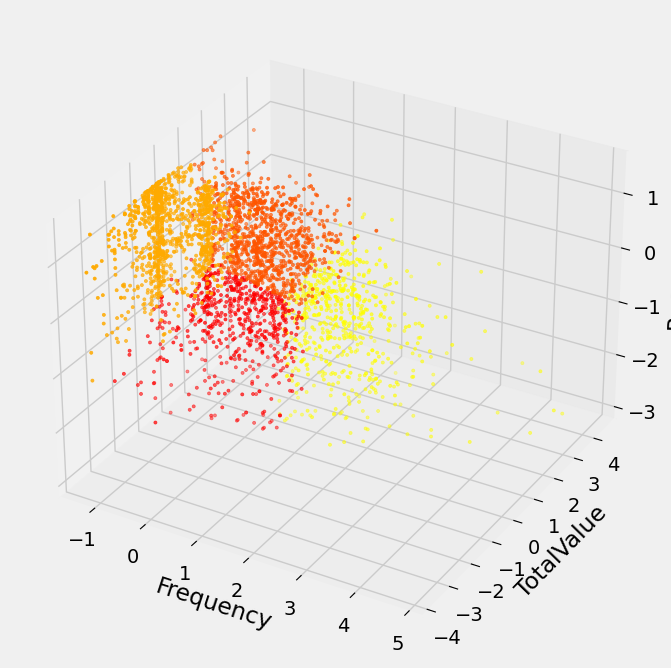

In [ ]:
# YOUR CODE HERE
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

xs =X_train.iloc[:,1]
ys = X_train.iloc[:,2]
zs = X_train.iloc[:,0]
ax.scatter(xs, ys, zs, s=5,c = kmeans.labels_,  cmap='autumn')

ax.set_xlabel('Frequency')
ax.set_ylabel('TotalValue')
ax.set_zlabel('Recency')

1.light orange - low frequency , high recency , total value is spread from -2 to 3 --> Casual/Passerby customers

2.red - low-medium frequency , low recency , total value is spread from 0 to 3  --> Lost customers

3.dark orange - medium frequency , high recency, high total value  --> Best customers

4.yellow - low recency, high frequency,high total value --> Almost lost customers




Text(0.5, 0, 'Labels')

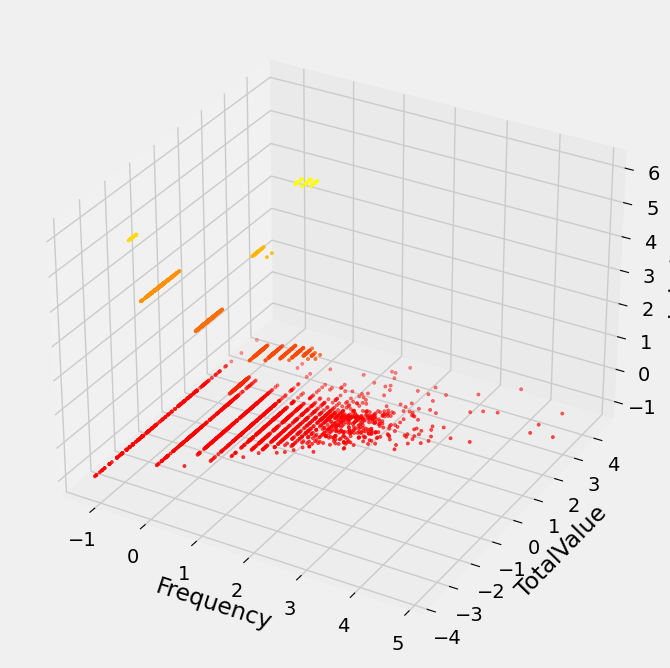

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

xs =X_train.iloc[:,1]
ys = X_train.iloc[:,2]
zs = dbscan.labels_
ax.scatter(xs, ys, zs, s=5,c = dbscan.labels_, cmap='autumn')

ax.set_xlabel('Frequency')
ax.set_ylabel('TotalValue')
ax.set_zlabel('Labels')

### Train a supervised algorithm on clustered data

This will allow us to predict cluster numbers (label) for each test data instance

* Create labelled data with k-means cluster labels
  
  **Hint**: [`kmeans.labels_`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
)
* Split the data into train and validation sets
* Train a supervised algorithm on the train data
* Find the accuracy of the model using validation data

In [ ]:
# YOUR CODE HERE
X_train['labels'] = kmeans.labels_
X_train.head()

,log_Recency,log_Frequency,log_TotalValue,labels
0,-2.393472,1.215649,1.185803,3
1,1.334383,-1.245179,-0.092855,0
2,-0.738816,0.406499,0.673787,1
3,1.005795,-0.533840,0.183523,2
4,1.100326,-0.117733,-0.100485,2


In [ ]:
def rfm_values(df):
    df_new = df.groupby(['labels']).agg({
        'log_Recency': 'mean',
        'log_Frequency': 'mean',
        'log_TotalValue': ['mean', 'count']}).round(0)

    return df_new

In [ ]:
rfm_values(X_train)

log_Recency log_Frequency log_TotalValue      
              mean          mean           mean count
labels                                               
0             -1.0          -0.0           -0.0   591
1              1.0          -1.0           -1.0  1128
2             -1.0           1.0            1.0   581
3              0.0           0.0            0.0  1007

In [ ]:
X = X_train.iloc[:, :-1]
y = X_train.iloc[:,-1]

In [ ]:
X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size = 0.30, random_state=42)

In [ ]:
# prompt: XGB CLASSIFIER

import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
# Create the XGBoost model
model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.08,
                           colsample_bytree=1, max_depth=7)

# Train the model
model.fit(X_train1, y_train1)

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_val)
f1_score = f1_score(y_pred, y_val, average='macro')
print('Accuracy:', accuracy)
print('F1 score:', f1_score)

Accuracy: 0.9828801611278952
F1 score: 0.981532796178935


In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train1, y_train1.ravel())
y_predict = log_reg.predict(X_val)
log_reg.score(X_val, y_val)

0.9909365558912386

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print(accuracy_score(y_predict, y_val))
print(f1_score(y_predict, y_val, average='macro'))

0.9909365558912386
0.9894168128342382


### Evaluation of Test Data
* Use the model to predict the labels for the Test data below
* Format the test data in the same format as the train data.
* Predict it with trained supervised ML model

In [ ]:
# Test set provided as below
test = pd.read_csv("Online_Retail_Test.csv")
test.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom


In [ ]:
df1 = eda(test)

Before dropping duplicates : (27096, 8)
After dropping duplicates : (27082, 8)
InvoiceNo         0
StockCode         0
Description      69
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     6817
Country           0
dtype: int64
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
Before Dropping Irrelevant StockCodes:

(19794, 8)
After Dropping Irrelevant StockCodes:

(19710, 8)
Lower, Upper Bounds -12.5 , 23.5
Number of records after IQR on Quantity - 16978 
Records Removed - 2732


In [ ]:
# YOUR CODE HERE
#df1 = df1[df1['UnitPrice'] > 0]

In [ ]:
df_testCopy = create_total(df1, col1='UnitPrice', col2='Quantity')

In [ ]:
df_CustomerHistory_test = findRecentTranscation(df_testCopy, 'InvoiceDate', 'CustomerID', 'Recency')
df_CustomerHistory_test.head(5)

,CustomerID,Recency
0,12347.0,2.0
1,12348.0,319.0
2,12349.0,19.0
3,12353.0,204.0
4,12354.0,232.0


In [ ]:
df_CustomerHistory_test = calculateFreq_Of_Transctions(df_testCopy, 'CustomerID', 'Total')
df_CustomerHistory_test.head()

,CustomerID,Recency,Frequency
0,12347.0,2.0,11
1,12348.0,319.0,1
2,12349.0,19.0,5
3,12353.0,204.0,2
4,12354.0,232.0,3


In [ ]:
df_CustomerHistory_test = calculateMonetryValue_Of_Transctions(df_testCopy, 'CustomerID', 'Total')
df_CustomerHistory_test.head()

,CustomerID,Recency,Frequency,TotalValue
0,12347.0,2.0,11,218.20
1,12348.0,319.0,1,41.76
2,12349.0,19.0,5,112.54
3,12353.0,204.0,2,59.70
4,12354.0,232.0,3,41.35


In [ ]:
X_test, df_CustomerHistory_test = (logTransform_N_Scale(df_CustomerHistory_test,
                          'Recency',
                          'Frequency',
                          'TotalValue'))
X_test[:5]

,log_Recency,log_Frequency,log_TotalValue
0,-2.393472,1.215649,1.185803
1,1.334383,-1.245179,-0.092855
2,-0.738816,0.406499,0.673787
3,1.005795,-0.533840,0.183523
4,1.100326,-0.117733,-0.100485


In [ ]:
X_test['label'] = kmeans.labels_
X_test.head()

,log_Recency,log_Frequency,log_TotalValue,label
0,-2.393472,1.215649,1.185803,3
1,1.334383,-1.245179,-0.092855,0
2,-0.738816,0.406499,0.673787,1
3,1.005795,-0.533840,0.183523,2
4,1.100326,-0.117733,-0.100485,2


In [ ]:
#X_test = X_test.drop('label', axis=1)
y_test = kmeans.fit_predict(X_test)

In [ ]:
X_test['label'] = y_test

In [ ]:
X = X_test.iloc[:, :-1]
y = X_test.iloc[:, -1]

In [ ]:
X.columns

Index(['log_Recency', 'log_Frequency', 'log_TotalValue'], dtype='object')

In [ ]:
# prompt: XGB CLASSIFIER

import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
# Create the XGBoost model
#model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.08, colsample_bytree=1, max_depth=7)

# Train the model
#model.fit(X,y)

# Make predictions on the validation set
y_pred = model.predict(X)

# Calculate the accuracy
accuracy = np.mean(y_pred == y)
f1_score = f1_score(y_pred, y, average='macro')
print('Accuracy:', accuracy)
print('F1 score:', f1_score)

Accuracy: 0.17750226791654067
F1 score: 0.2514158083020276


In [ ]:
log_reg.score(X, y)
y_pred_test = log_reg.predict(X)
print(accuracy_score(y_pred_test, y))
print(f1_score(y_pred_test, y, average='macro'))

0.5167825824009676
0.4983236968168909


### Report Analysis

- Discuss the pros and cons of removing the missing values vs replacing with the mean values
- Based on the visualization of clusters, comment on the difference in buying patterns of each cluster
- What other methods could be used to determine the optimal no. of clusters?